### Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from sklearn.preprocessing import MinMaxScaler
import datetime 
import time
from numba import jit

import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.stattools import durbin_watson

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.vector_ar.var_model import VAR

from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import regularizers


from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint

In [5]:
import seaborn as sns
sns.set()

In [6]:
import warnings
warnings.filterwarnings("ignore")

### Dataset

In [7]:
url = 'https://raw.githubusercontent.com/Somil-Gupta/ForexML/main/Dataset_Forex.csv'
data = pd.read_csv(url, parse_dates=['Date'])
data = data.set_index("Date")
#data = data.dropna()

In [8]:
data.head()

,JPY-INR,IR_India,IR_Japan,TotalReserves_India,TotalReserves_Japan,CPI_India,CPI_Japan,IIP_India,IIP_Japan,MoneySupply_India,MoneySupply_Japan,SharePrice_India,SharePrice_Japan,NetTrade_India,NetTrade_Japan
Date,,,,,,,,,,,,,,,
1994-04-01,0.3088,12.0,1.75,1.543578e+10,1.075991e+11,22.30,97.9,26.96,97.25,5.018950e+10,1.402182e+12,13.98,103.67,-4.662191e+07,1.096104e+10
1994-05-01,0.2995,12.0,1.75,1.583023e+10,1.099333e+11,22.55,98.0,27.40,97.15,5.147001e+10,1.296305e+12,13.73,105.85,-1.739743e+07,8.672703e+09
1994-06-01,0.3189,12.0,1.75,1.672480e+10,1.145591e+11,22.97,97.6,28.11,98.37,5.193161e+10,1.374663e+12,15.12,108.55,-1.150851e+08,1.086038e+10
1994-07-01,0.3134,12.0,1.75,1.788632e+10,1.167992e+11,23.30,97.2,28.36,99.38,5.233237e+10,1.431192e+12,15.01,106.56,-2.526126e+08,1.189820e+10
1994-08-01,0.3134,12.0,1.75,1.799239e+10,1.189365e+11,23.55,97.6,28.53,100.19,5.050790e+10,1.337759e+12,16.11,106.24,-1.948852e+08,8.502712e+09


In [9]:
# billion dollars
billion = 10**9

### Visualization

In [10]:
#plt.style.available

In [11]:
def plotter(index, india, japan, title):
    plt.figure(figsize=(15,8))
    #plt.style.use('ggplot')
    plt.title(title)
    #plt.xlabel("Date")
    #plt.ylabel("Prices")
    plt.plot(index, india, label="India")
    plt.plot(index, japan, label="Japan")
    plt.legend(loc='upper right')

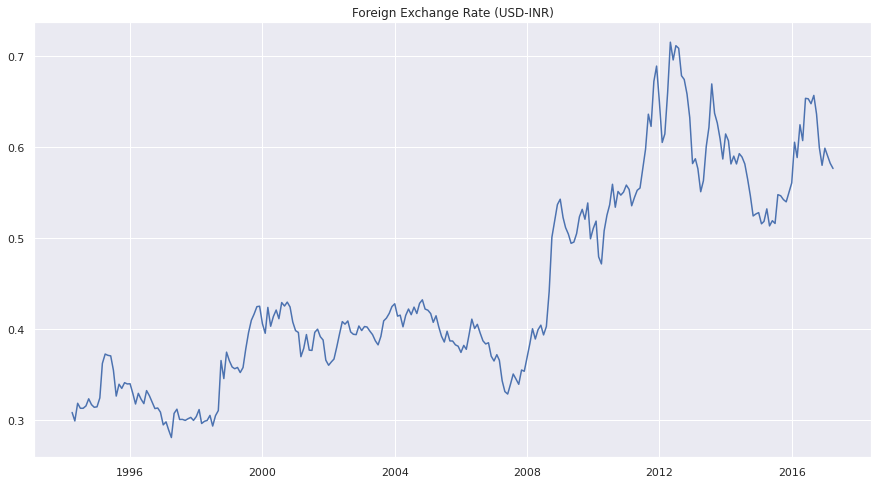

In [12]:
plt.figure(figsize=(15,8))
plt.title("Foreign Exchange Rate (USD-INR)")
plt.plot(data.index, data["JPY-INR"])

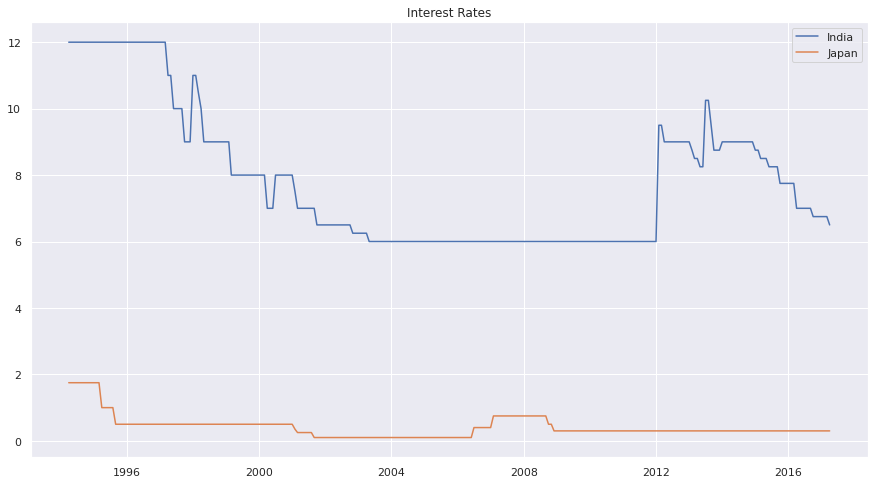

In [13]:
plotter(data.index, data["IR_India"], data["IR_Japan"], "Interest Rates")

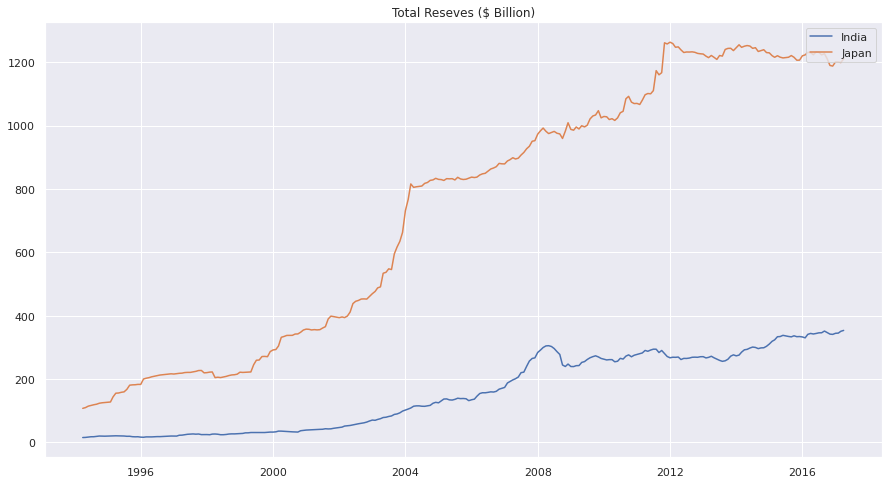

In [14]:
plotter(data.index, data["TotalReserves_India"]/billion, data["TotalReserves_Japan"]/billion, "Total Reseves ($ Billion)")

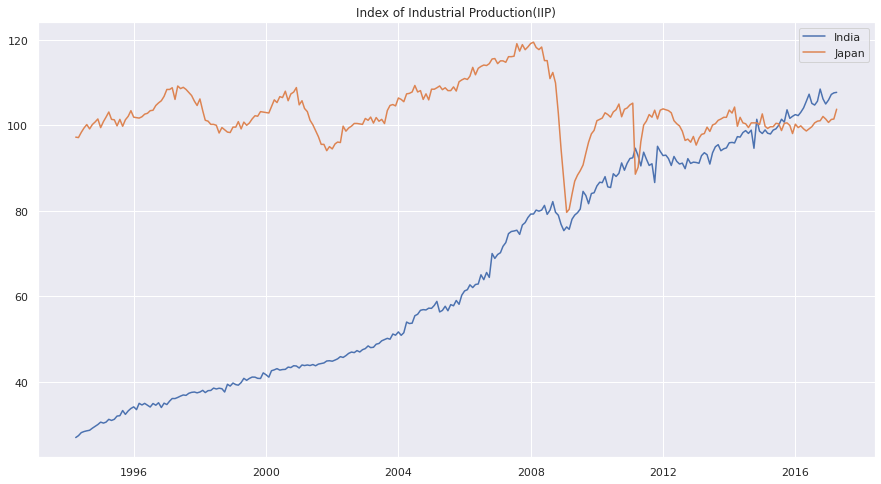

In [15]:
plotter(data.index, data["IIP_India"], data["IIP_Japan"], "Index of Industrial Production(IIP)")

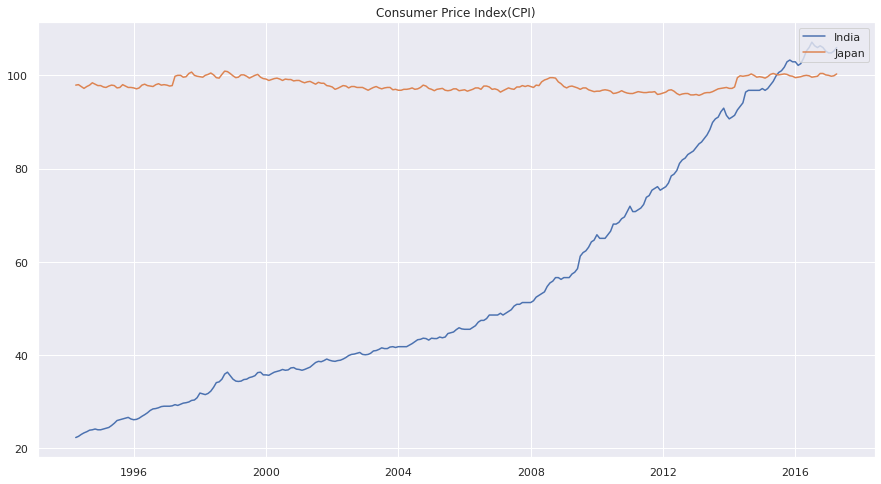

In [16]:
plotter(data.index, data["CPI_India"], data["CPI_Japan"], "Consumer Price Index(CPI)")

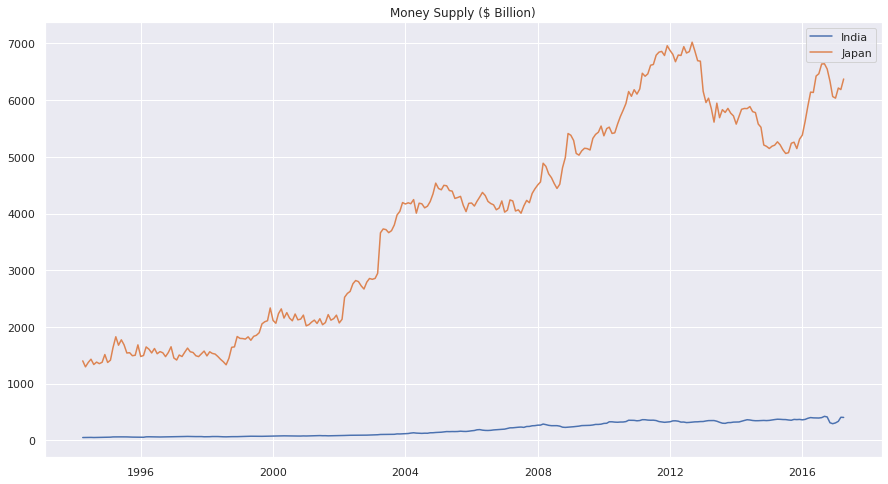

In [17]:
plotter(data.index, data["MoneySupply_India"]/billion, data["MoneySupply_Japan"]/billion, "Money Supply ($ Billion)")

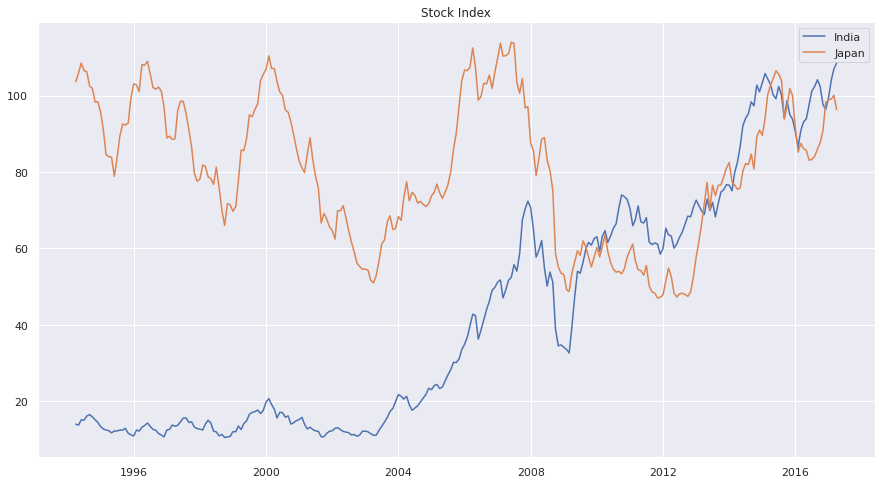

In [18]:
plotter(data.index, data["SharePrice_India"], data["SharePrice_Japan"], "Stock Index")

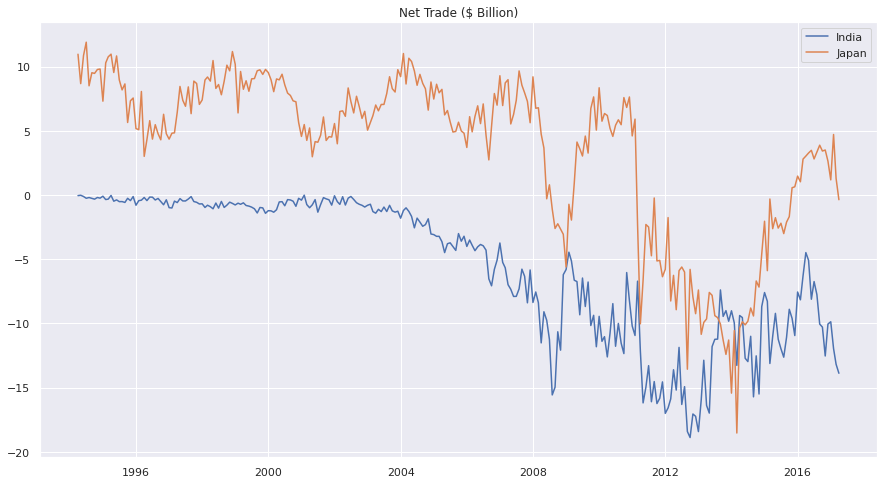

In [19]:
plotter(data.index, data["NetTrade_India"]/billion, data["NetTrade_Japan"]/billion, "Net Trade ($ Billion)")

### Statistical Tests

#### Augmented Dickey Fuller Test

In [20]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {val:.3}')

    if p_value <= signif:
        print(f" => P-Value = {p_value:.3}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value:.3}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")  

#### Granger's Casuality Test

In [21]:
## NOTE: 
## 1. Time series shud be stationary before running this test (ADF test performed)
## 2. Check for the lag order to determine the maximum lag length for the Granger causality analysis


## Function for Causality Test
from statsmodels.tsa.stattools import grangercausalitytests
maxlag = 12
test = 'ssr_chi2test'
def granger_causation_matrix(data, variables, test = 'ssr_chi2test', verbose=False):
  """Check Granger Causality of all possible combinations of the Time series.
  The rows are the response variable, columns are predictors. The values in the table 
  are the P-Values. P-Values lesser than the significance level (0.05), implies 
  the Null Hypothesis that the coefficients of the corresponding past values is 
  zero, that is, the X does not cause Y can be rejected.

  data      : pandas dataframe containing the time series variables
  variables : list containing names of the time series variables.
  """
  X_train = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
  for c in X_train.columns:
    for r in X_train.index:
      test_result = grangercausalitytests(data[[r,c]], maxlag=maxlag, verbose=False)
      p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
      if verbose:
        print(f'Y={r}, X={c}, P Values={p_values}')
      min_p_value = np.min(p_values)
      X_train.loc[r,c] = min_p_value
  X_train.columns = [var + '_x' for var in variables]
  X_train.index = [var + '_y' for var in variables]
  return X_train

#### Johansen Cointegration Test

In [22]:
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

#### Durbin Watson Test

In [23]:
def DWstats(df, model):
  out = durbin_watson(model.resid)
  def adjust(val, length= 18): return str(val).ljust(length)
  for col, val in zip(df.columns, out):
    print(adjust(col), ':', round(val, 2))

### Feature Engineering

In [24]:
#creating lag features
def lag_feats(df, target_col, lags):
    df = pd.DataFrame(df)
    for i in lags:
        df['_'.join([target_col, 'lag', str(i)])] = df[target_col].shift(i).values #+ np.random.normal(scale=1.5, size=(len(df),))
    return df

#creating rolling mean features
def rmean_feats(df, target_col, windows, min_periods=2, shift=1, win_type=None):
    df = pd.DataFrame(df)
    for w in windows:
        df['_'.join([target_col, 'rmean', str(w)])] = df[target_col].shift(shift).rolling(window=w, min_periods=min_periods, win_type=win_type).mean().values #+ np.random.normal(scale=1.6, size=(len(df),))
    return df
    
    
# Creating exponentially weighted mean features
def ewm_feats(df, target_col, alpha=[0.9], shift=1):
    df = pd.DataFrame(df)
    for a in alpha:
        df['_'.join([target_col, 'ewm', str(a)])] = df[target_col].shift(shift).ewm(alpha=a).mean().values
    return df

# create a differenced series
def difference(data, target_col, interval=1):
    df = pd.DataFrame(data)
    dataset = df[target_col].shift(1).values
    df['diff'] = [dataset.item(i) - dataset.item(i - interval) if i>=(interval+1) else np.nan for i in range(len(df))]
    return df

def to_supervised(data, lags = np.arange(1,4), windows = [3], alpha = [0.9]):
    #### All the date features ####
    data = pd.DataFrame(data).copy()
    df = data.iloc[:,[0]].copy()
    df = lag_feats(df, data.columns[0], lags)
    cnt = 0
    for name, column in data.iteritems():
      if cnt == 0:
        cnt = cnt + 1
        pass
      else:
        df[name] = column
        df = lag_feats(df, name, lags)
        df = df.drop([name], axis=1)
    #df = rmean_feats(df, measure, windows)
    #df = ewm_feats(df, measure, alpha)
    #df = difference(df, measure)
    df["bias"] = 1
    df.dropna(inplace=True)

    return df

### Data Processing

In [25]:
def scaling(data):
  #Scale the data
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaler = scaler.fit(df.values)
  scaled = scaler.transform(df.values)
  scaled_df = pd.DataFrame(scaled)
  scaled_df.columns = df.columns
  scaler1 = MinMaxScaler(feature_range=(0, 1))
  scaler1.min_, scaler1.scale_ = scaler.min_[0], scaler.scale_[0]
  return scaled_df, scaler1

def split(data, n_train, n_pred):
    #split into sequential train and split
    train = data[-(n_train+n_pred):-n_pred].copy()
    test = data[-n_pred:].copy()
    train = pd.DataFrame(train)
    test = pd.DataFrame(test)
    return train, test    

def xy(df):
    arr = np.array(df)
    return arr[:,1:], arr[:,0:1].squeeze()

def reshaper(df, time_steps=1):
    return df.reshape(df.shape[0],time_steps,df.shape[1])

In [26]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

### Forecasting Measure

In [27]:
def percentage_error(actual, predicted):
    res = np.empty(len(actual))
    for j in range(len(actual)):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(actual, predicted):
    return np.mean(np.abs(percentage_error(np.asarray(actual), np.asarray(predicted)))) * 100

def mean_percentage_error(actual, predicted):
    return np.mean(percentage_error(np.asarray(actual), np.asarray(predicted))) * 100

def rmse(actual, predicted):
    return np.sqrt(mse(actual, predicted))

def accuracy(actual, predicted):
    acc = 100 - mean_absolute_percentage_error(actual, predicted)
    return acc

def rsq(actual, predicted):
    return r2_score(actual, predicted)

In [28]:
def forecast(actual, predicted):
  print(f' Mean Absolute Percentage Error    = {mean_absolute_percentage_error(actual, predicted):.3}%')
  print(f' Mean Percentage Error             = {mean_percentage_error(actual, predicted):.3}%')
  print(f' Root Mean Squared Error           = {rmse(actual, predicted):.3}')
  print(f' R squared                         = {rsq(actual, predicted):.3}')
  print(f' Accuracy                          = {accuracy(actual, predicted):.3}%')

### Model Definition

In [29]:
#from tensorflow.keras.callbacks import Callback
class EarlyStoppingByLoss(Callback):
    def __init__(self, monitor='loss', value=0.001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True
            
            
def fit_lstm(X_train, y_train, n_epochs, reg, cells=50):
    model = Sequential()
    model.add(LSTM(cells, activation='relu', return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=reg))
    #model.add(Dropout(0.5))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    es = EarlyStoppingByLoss(monitor='loss', value=0.001, verbose=2)
    mc = ModelCheckpoint('best_model.h5', monitor='loss', save_best_only=True, verbose=1)
    callbacks = [es, mc]
    history = model.fit(X_train, y_train, epochs=n_epochs, verbose=2, shuffle=False, callbacks = callbacks)
    return model

In [30]:
def fit_ridge(X_train, y_train):
    model = Ridge()
    model.fit(X_train, y_train)
    return model

def fit_elastic(X_train, y_train):
    model = ElasticNet(random_state=0)
    model.fit(X_train, y_train)
    return model

def fit_rf(X_train, y_train, n_est =100):
    model = RandomForestRegressor(n_estimators=n_est, criterion='mse')
    model.fit(X_train, y_train)
    return model

def fit_xgb(X_train, y_train):
    model = xgb.XGBRegressor(n_estimators=n_est)
    model.fit(X_train, y_train)
    return model

def fit_svm(X_train, y_train, kernel='rbf'):
    model = SVR(kernel = 'rbf')
    model.fit(X_train, y_train)
    return model

def fit_lgb(X_train, y_train, n_est =1000):
    model = lgb.LGBMRegressor(n_estimators=n_est)
    model.fit(X_train, y_train)
    return model

In [31]:
def fit_xgb_opt(X_train, y_train):
    # A parameter grid for XGBoost
    params = {'min_child_weight':[3,4,5], 
              'gamma':[i/10.0 for i in range(2,6)],  
              'subsample':[i/10.0 for i in range(6,11)],
              'colsample_bytree':[i/10.0 for i in range(6,11)], 
              'max_depth': [2,3,4]
              }

    # Initialize XGB and GridSearch
    model = xgb.XGBRegressor(nthread=-1, objective ='reg:squarederror')
    # Fitting GridCV
    grid = GridSearchCV(model, params)
    grid.fit(X_train, y_train)
    return grid

def fit_rf_opt(X_train, y_train):
    # A parameter grid for RF
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    # Create the random grid
    params = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}

    # Initialize XGB and GridSearch
    model = RandomForestRegressor(criterion='mse')
    # Fitting GridCV
    grid = GridSearchCV(model, params)
    grid.fit(X_train, y_train)
    return grid

def fit_svm_opt(X_train, y_train):
    # A parameter grid for SVM
    params = {'kernel': ('linear', 'poly', 'rbf', 'sigmoid', 'precomputed'),
              'C':[1.5, 10],
              'gamma': [1e-7, 1e-4],
              'epsilon':[0.1,0.2,0.5,0.3]}

    # Initialize SVM and GridSearch
    model = SVR()
    # Fitting GridCV
    grid = GridSearchCV(model, params)
    grid.fit(X_train, y_train)
    return grid

### Model Execution

In [32]:
  def dl_model(df, n_train, n_pred, lags, windows, alpha, n_epochs, cells, reg):
                
    scaled_df, scaler = scaling(df)
    #scaled_df.head()
    
    lags = np.arange(1,4)
    spv_df = to_supervised(scaled_df, lags, windows, alpha)

    train, test = split(spv_df, n_train, n_test)

    X_train, y_train = xy(train)
    X_test, y_test = xy(test)
    X_train_lstm = reshaper(X_train)
    X_test_lstm = reshaper(X_test)
    
    # model fitting
    fit_before = time.time()
    #########For LSTM ##########
    model = fit_lstm(X_train_lstm, y_train, n_epochs, reg, cells)
    yhat_train = model.predict(X_train_lstm)  ##use this line for LSTM
    yhat_test = model.predict(X_test_lstm)
    ############################
    
    fit_after = time.time()
    fit_time = fit_after - fit_before
    
    y_train_inv = scaler.inverse_transform(y_train.reshape(-1,1))
    yhat_train_inv = scaler.inverse_transform(yhat_train.reshape(-1,1))
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))
    yhat_test_inv = scaler.inverse_transform(yhat_test.reshape(-1,1))

    print(f'    Forecasting Measures for LSTM on training', "\n   ", '-'*47)
    forecast(y_train_inv, yhat_train_inv)
    print(f'    Forecasting Measures for LSTM on testing', "\n   ", '-'*47)
    forecast(y_test_inv, yhat_test_inv)

    return yhat_test_inv

In [33]:
def ml_model(df, n_train, n_pred, lags, windows, alpha):
                
    scaled_df, scaler = scaling(df)
    #scaled_df.head()
    
    lags = np.arange(1,4)
    spv_df = to_supervised(scaled_df, lags, windows, alpha)

    train, test = split(spv_df, n_train, n_test)

    X_train, y_train = xy(train)
    X_test, y_test = xy(test)


    # model fitting
    fit_before = time.time()
    #########For other models#######
    #model = fit_rf(X_train, y_train)
    #model = fit_xgb(X_train, y_train)
    model = fit_svm(X_train, y_train)
    #model = fit_lgb(X_train, y_train)
    #model = fit_ridge(X_train, y_train)
    #model = fit_elastic(X_train, y_train)
    
    ##use this line for models other than XGB##
    yhat_train = model.predict(X_train)     
    yhat_test = model.predict(X_test)
    ##########################################
    #grid = fit_xgb_opt(X_train, y_train)
    #grid = fit_svm_opt(X_train, y_train)
    #grid = fit_rf_opt(X_train, y_train)

    ############## Predicting on XGB ##############################
    #yhat_train = grid.best_estimator_.predict(X_train)
    #yhat_test = grid.best_estimator_.predict(X_test)
    #print(f'Selected Parameters for XGB Regressor after GridSearch Optimization', "\n", '-'*47)
    #print(grid.best_estimator_)
    ################################################################
    
    fit_after = time.time()
    fit_time = fit_after - fit_before
    
    y_train_inv = scaler.inverse_transform(y_train.reshape(-1,1))
    yhat_train_inv = scaler.inverse_transform(yhat_train.reshape(-1,1))
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))
    yhat_test_inv = scaler.inverse_transform(yhat_test.reshape(-1,1))

    print(f'    Forecasting Measures for SVM on training', "\n   ", '-'*47)
    forecast(y_train_inv, yhat_train_inv)
    print(f'    Forecasting Measures for SVM on testing', "\n   ", '-'*47)
    forecast(y_test_inv, yhat_test_inv)

    return yhat_test_inv

### Final Exec

#### Data Declaration

In [34]:
df = data[['JPY-INR']].copy()
data.columns

Index(['JPY-INR', 'IR_India', 'IR_Japan', 'TotalReserves_India',
       'TotalReserves_Japan', 'CPI_India', 'CPI_Japan', 'IIP_India',
       'IIP_Japan', 'MoneySupply_India', 'MoneySupply_Japan',
       'SharePrice_India', 'SharePrice_Japan', 'NetTrade_India',
       'NetTrade_Japan'],
      dtype='object')

In [35]:
df['IR'] = data['IR_Japan'] - data['IR_India'] 
df['Total Reserves'] = (data['TotalReserves_Japan'] - data['TotalReserves_India'])/billion
df['CPI'] = data['CPI_Japan'] - data['CPI_India']
df['IIP'] = data['IIP_Japan'] - data['IIP_India']
df['Moeny Supply'] = (data['MoneySupply_Japan'] - data['MoneySupply_India'])/billion
df['Stock Price'] = data['SharePrice_Japan'] - data['SharePrice_India']
df['Net Trade'] = (data['NetTrade_Japan'] - data['NetTrade_India'])/billion

In [36]:
df.head()

,JPY-INR,IR,Total Reserves,CPI,IIP,Moeny Supply,Stock Price,Net Trade
Date,,,,,,,,
1994-04-01,0.3088,-10.25,92.163285,75.60,70.29,1351.992477,89.69,11.007659
1994-05-01,0.2995,-10.25,94.103079,75.45,69.75,1244.835328,92.12,8.690100
1994-06-01,0.3189,-10.25,97.834330,74.63,70.26,1322.731403,93.43,10.975461
1994-07-01,0.3134,-10.25,98.912843,73.90,71.02,1378.859668,91.55,12.150816
1994-08-01,0.3134,-10.25,100.944092,74.05,71.66,1287.250941,90.13,8.697597


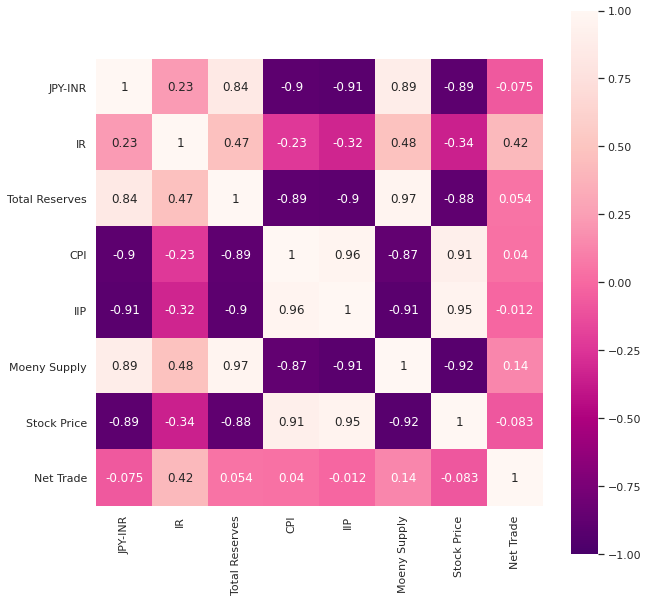

In [37]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df.corr(), annot = True, fmt='.2g', square=True, vmin=-1, vmax=1, center= 0, cmap="RdPu_r", ax=ax)

In [38]:
n_train = round(len(df)*0.9)
n_test = len(df) - n_train

In [39]:
y_test = data.iloc[-n_test:,0].values
index_test = data.iloc[-n_test:,0].index
len(y_test)

28

In [40]:
lags = np.arange(1,4)
windows = [3, 5, 7, 10, 15]
#windows = np.arange(2,7)
alpha = [0.9]
n_epochs = 100
cells = 10
reg = regularizers.l1_l2(0.0, 0.01)

#### ML & DL models

In [41]:
yhat_dl = dl_model(df, n_train, n_test, lags, windows, alpha, n_epochs, cells, reg)

Epoch 1/100
8/8 - 2s - loss: 0.3359

Epoch 00001: loss improved from inf to 0.33585, saving model to best_model.h5
Epoch 2/100
8/8 - 0s - loss: 0.3072

Epoch 00002: loss improved from 0.33585 to 0.30720, saving model to best_model.h5
Epoch 3/100
8/8 - 0s - loss: 0.2844

Epoch 00003: loss improved from 0.30720 to 0.28439, saving model to best_model.h5
Epoch 4/100
8/8 - 0s - loss: 0.2644

Epoch 00004: loss improved from 0.28439 to 0.26436, saving model to best_model.h5
Epoch 5/100
8/8 - 0s - loss: 0.2467

Epoch 00005: loss improved from 0.26436 to 0.24673, saving model to best_model.h5
Epoch 6/100
8/8 - 0s - loss: 0.2307

Epoch 00006: loss improved from 0.24673 to 0.23067, saving model to best_model.h5
Epoch 7/100
8/8 - 0s - loss: 0.2160

Epoch 00007: loss improved from 0.23067 to 0.21598, saving model to best_model.h5
Epoch 8/100
8/8 - 0s - loss: 0.2027

Epoch 00008: loss improved from 0.21598 to 0.20269, saving model to best_model.h5
Epoch 9/100
8/8 - 0s - loss: 0.1906

Epoch 00009: lo

In [42]:
yhat_xgb = ml_model(df, n_train, n_test, lags, windows, alpha)

    Forecasting Measures for SVM on training 
    -----------------------------------------------
 Mean Absolute Percentage Error    = 4.94%
 Mean Percentage Error             = -1.91%
 Root Mean Squared Error           = 0.0242
 R squared                         = 0.948
 Accuracy                          = 95.1%
    Forecasting Measures for SVM on testing 
    -----------------------------------------------
 Mean Absolute Percentage Error    = 5.28%
 Mean Percentage Error             = 3.34%
 Root Mean Squared Error           = 0.0392
 R squared                         = 0.277
 Accuracy                          = 94.7%


In [43]:
yhat_rf = ml_model(df, n_train, n_test, lags, windows, alpha)

    Forecasting Measures for SVM on training 
    -----------------------------------------------
 Mean Absolute Percentage Error    = 4.94%
 Mean Percentage Error             = -1.91%
 Root Mean Squared Error           = 0.0242
 R squared                         = 0.948
 Accuracy                          = 95.1%
    Forecasting Measures for SVM on testing 
    -----------------------------------------------
 Mean Absolute Percentage Error    = 5.28%
 Mean Percentage Error             = 3.34%
 Root Mean Squared Error           = 0.0392
 R squared                         = 0.277
 Accuracy                          = 94.7%


In [44]:
yhat_svm = ml_model(df, n_train, n_test, lags, windows, alpha)

    Forecasting Measures for SVM on training 
    -----------------------------------------------
 Mean Absolute Percentage Error    = 4.94%
 Mean Percentage Error             = -1.91%
 Root Mean Squared Error           = 0.0242
 R squared                         = 0.948
 Accuracy                          = 95.1%
    Forecasting Measures for SVM on testing 
    -----------------------------------------------
 Mean Absolute Percentage Error    = 5.28%
 Mean Percentage Error             = 3.34%
 Root Mean Squared Error           = 0.0392
 R squared                         = 0.277
 Accuracy                          = 94.7%


#### Statistical Models (VAR)

In [45]:
# ADF Test on each column
for name, column in df.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "JPY-INR" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.2868
 No. Lags Chosen       = 0
 Critical value 1%     = -3.45
 Critical value 5%     = -2.87
 Critical value 10%    = -2.57
 => P-Value = 0.635. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "IR" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.6122
 No. Lags Chosen       = 3
 Critical value 1%     = -3.45
 Critical value 5%     = -2.87
 Critical value 10%    = -2.57
 => P-Value = 0.477. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Total Reserves" 
    -----------------------------------------------
 Null Hypothesis: Data has unit

In [46]:
# 1st difference
df_differenced = df.diff().dropna()
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "JPY-INR" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -15.3205
 No. Lags Chosen       = 0
 Critical value 1%     = -3.45
 Critical value 5%     = -2.87
 Critical value 10%    = -2.57
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "IR" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -11.7855
 No. Lags Chosen       = 2
 Critical value 1%     = -3.45
 Critical value 5%     = -2.87
 Critical value 10%    = -2.57
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Total Reserves" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    

In [47]:
# Granger Causality test matrix
granger_causation_matrix(df_differenced, df_differenced.columns)

,JPY-INR_x,IR_x,Total Reserves_x,CPI_x,IIP_x,Moeny Supply_x,Stock Price_x,Net Trade_x
JPY-INR_y,1.0000,0.0299,0.0143,0.0184,0.0034,0.1486,0.0579,0.0017
IR_y,0.4074,1.0000,0.0000,0.1554,0.0000,0.5368,0.3078,0.0000
Total Reserves_y,0.0553,0.3454,1.0000,0.0033,0.0000,0.0006,0.0555,0.0012
CPI_y,0.0303,0.3089,0.1618,1.0000,0.0057,0.0002,0.0414,0.0656
IIP_y,0.0017,0.6997,0.0548,0.4538,1.0000,0.0782,0.5240,0.0209
Moeny Supply_y,0.0000,0.1440,0.0008,0.0001,0.1932,1.0000,0.0938,0.1191
Stock Price_y,0.0859,0.4019,0.0396,0.0114,0.5210,0.9384,1.0000,0.4792
Net Trade_y,0.0129,0.0579,0.0036,0.4201,0.0000,0.1050,0.1442,1.0000


In [48]:
cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
JPY-INR ::  160.37    > 143.6691  =>   True
IR     ::  101.96    > 111.7797  =>   False
Total Reserves ::  69.45     > 83.9383   =>   False
CPI    ::  40.52     > 60.0627   =>   False
IIP    ::  24.97     > 40.1749   =>   False
Moeny Supply ::  12.9      > 24.2761   =>   False
Stock Price ::  6.53      > 12.3212   =>   False
Net Trade ::  2.19      > 4.1296    =>   False


In [49]:
#scaled_df, scaler = scaling(df)
train, test = split(df, n_train, n_test)
#act_train, act_test = split(df_differenced, n_train, n_test)

In [50]:
# Lag order selection for VAR
model = VAR(endog = train)
for i in range(1,13):
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  8.736808573747611
BIC :  9.756836274247123
FPE :  6229.576775497611
HQIC:  9.14743311307055 

Lag Order = 2
AIC :  8.384018120065871
BIC :  10.316312912703138
FPE :  4384.19759275405
HQIC:  9.161975128932514 

Lag Order = 3
AIC :  8.460912331308952
BIC :  11.310775368652337
FPE :  4753.0653514802025
HQIC:  9.608419636792032 

Lag Order = 4
AIC :  8.316324924687645
BIC :  12.089109282172577
FPE :  4144.351476168157
HQIC:  9.835621933259883 

Lag Order = 5
AIC :  8.456142678801228
BIC :  13.157254063621597
FPE :  4826.533072080581
HQIC:  10.349490662559402 

Lag Order = 6
AIC :  8.644240286735872
BIC :  14.279137759120626
FPE :  5937.645681157717
HQIC:  10.91392267438948 

Lag Order = 7
AIC :  8.535741265999103
BIC :  15.109937973137322
FPE :  5474.456121303974
HQIC:  11.184063938717966 

Lag Order = 8
AIC :  8.632750721187179
BIC :  16.151814644071578
FPE :  6261.699290445843
HQIC:  11.662042313404541 

Lag Order = 9
AIC :  8.705354302109228
BIC :  17.17490901557474

In [51]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,31.77,31.89,6.264e+13,31.82
1,8.969,10.02*,7858.,9.394*
2,8.603,10.59,5460.,9.405
3,8.677,11.60,5906.,9.857
4,8.519*,12.38,5084.*,10.08
5,8.642,13.44,5828.,10.58
6,8.813,14.55,7054.,11.13
7,8.673,15.35,6311.,11.36
8,8.751,16.36,7092.,11.82
9,8.768,17.31,7584.,12.21


In [52]:
### Thus selected lag order = 4 according to above AIC, FPE & HQIC

In [53]:
## Fitting VAR model
model_fitted = model.fit(4)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 19, May, 2021
Time:                     15:30:58
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    12.0891
Nobs:                     245.000    HQIC:                   9.83562
Log likelihood:          -3535.87    FPE:                    4144.35
AIC:                      8.31632    Det(Omega_mle):         1508.09
--------------------------------------------------------------------
Results for equation JPY-INR
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                     0.110213         0.028001            3.936           0.000
L1.JPY-INR                1.062691         0.071938           14.772           0.000
L1.IR                    -0.004086        

In [54]:
DWstats(train, model_fitted)

JPY-INR            : 2.05
IR                 : 2.01
Total Reserves     : 2.11
CPI                : 1.97
IIP                : 1.98
Moeny Supply       : 1.99
Stock Price        : 2.01
Net Trade          : 1.96


In [55]:
lag_order = model_fitted.k_ar
print('lag_order =' ,lag_order)  #> 2

# Input data for forecasting
forecast_input = train.values[-lag_order:]
nobs = len(test)
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps= nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_1d') ##bUse 2d or 1d acc to I(d)
yhat_test_var = df_forecast.iloc[:,0]

lag_order = 4


In [56]:
#df_results = invert_transformation(train, df_forecast, second_diff=False) 
#yhat_test_inv = df_results.iloc[:,0]

In [57]:
y_test =  test.iloc[:,0].values

In [58]:
forecast(y_test,yhat_test_var)

 Mean Absolute Percentage Error    = 5.09%
 Mean Percentage Error             = -3.56%
 Root Mean Squared Error           = 0.0387
 R squared                         = 0.296
 Accuracy                          = 94.9%


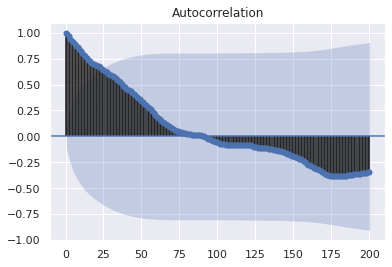

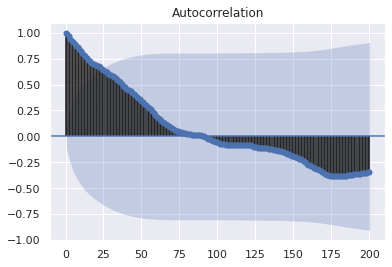

In [59]:
sm.graphics.tsa.plot_acf(df.iloc[:,0].values.squeeze(), lags=200)

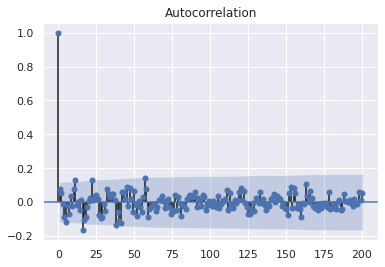

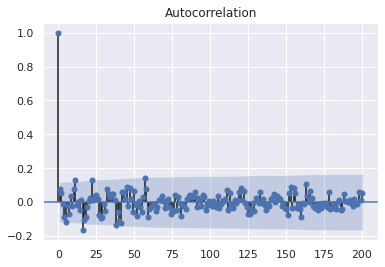

In [60]:
sm.graphics.tsa.plot_acf(df_differenced.iloc[:,0].values.squeeze(), lags=200)

#### All Predictions

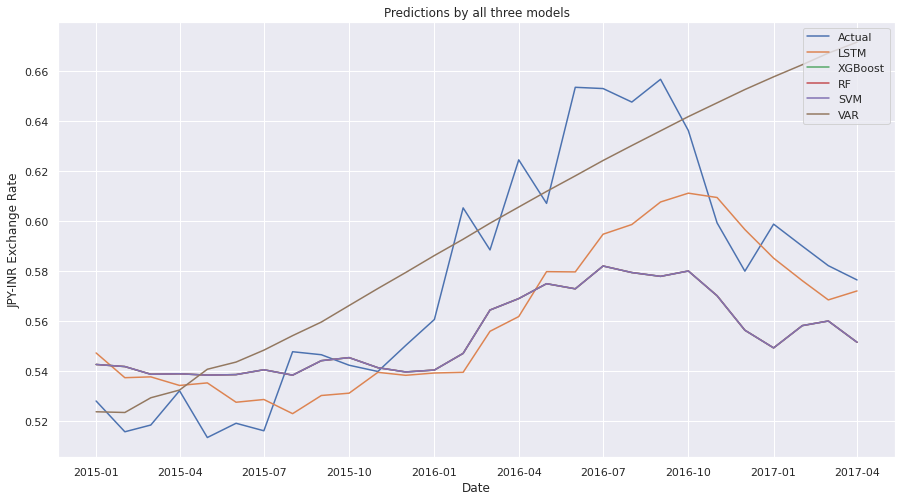

In [61]:
plt.figure(figsize=(15,8))
#plt.style.use('ggplot')
plt.title("Predictions by all three models")
plt.xlabel("Date")
plt.ylabel("JPY-INR Exchange Rate")
plt.plot(index_test, y_test, label="Actual")
plt.plot(index_test, yhat_dl, label="LSTM")
plt.plot(index_test, yhat_xgb, label="XGBoost")
plt.plot(index_test, yhat_rf, label="RF")
plt.plot(index_test, yhat_svm, label="SVM")
plt.plot(index_test, yhat_test_var, label="VAR")
plt.legend(loc='upper right')

In [62]:
vis = [1,3,4,5,6,7,8,0]
vis[-3:]

[7, 8, 0]